# Exercise 1

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import copy
%matplotlib inline

In [2]:
# Returns all possible powersets, given an iterable, as a list
def powerset(iterable):
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(1, len(s)+1))

In [3]:
# Given a Graph G this function returns a list of all possible cuts
# A cut [set_o, set_d] is a list made up of two lists, representing the partitions
# containing the origin node and destination node respectively
def cuts_compute(G):
    cuts=[]
    nodes=list(G.nodes)
    nodes.remove("d")
    nodes.remove("o")
    
    #generate powersets of nodes without origin and destination nodes
    sets_tmp=list(powerset(nodes))
    
    #generate all possible origin partitions
    sets_o=[]
    for set_tmp in sets_tmp:
        tmp=list(set_tmp)
        tmp.append("o")
        sets_o.append(tmp)
    sets_o.append(["o"])

    #given an origin partition generate the respective destination partition
    for set_o in sets_o:
        set_d=[]
        for node in G.nodes:
            if node not in set_o:
                set_d.append(node)
        #save the possible cut in "cuts" list
        cuts.append([set_o, set_d])

    
    return cuts

In [4]:
# Starting from a graph ("G") and a list of possible cuts ("cuts") , returns all "min capacity" cuts and the "min capacity" value 
def min_cuts_select(cuts, G):
    min_capacity=np.inf
    min_cuts=[]
    
    for cut in cuts:
        c=0
        #generate possible edges from combination of nodes from origin and destination partition
        possible_edges = list(itertools.product(cut[0], cut[1]))
        
        for edge in possible_edges:
            #if the edge exists in the graph, add its capacity to the total capacity of the cut ("c")
            if edge in G.edges:
                c+=G[edge[0]][edge[1]]["capacity"]
        
        if c==min_capacity:
            min_cuts.append([cut[0], cut[1]])
        if c<min_capacity:
            min_capacity=c
            min_cuts=[]
            min_cuts.append([cut[0], cut[1]])

    return min_capacity, min_cuts

In [5]:
# Given a graph "G" and a list of possible cuts ("cuts"), 
# returns the sum of all "cut capacities"
def sum_cut_capacities(cuts, G):
    c=0
    for cut in cuts:
        possible_edges = list(itertools.product(cut[0], cut[1]))
        #if the edge exists in the graph, add its capacity to the total capacity of the all cuts ("c")
        for edge in possible_edges:
            if edge in G.edges:
                c+=G[edge[0]][edge[1]]["capacity"]
        

    return c

In [6]:
# This recursive function takes as input a graph ("G"), a possible cut ("cut_nodes") in the form of a list [set_o, set_d] made up of two lists, representing the partitions containing the origin node and destination node respectively,
# the amount of capacity ("available_capaciry") that can still be added to edges and the list of edges which have already received a unit of bonus capacity ("added_capacities")
# We iteratively add capacities on edges of a previously computed cut, then for each change in the graph capacities the function is called recursively for each new min_cut and with one less unit of available capacity
# when the available capacity reaches value zero, we compute the maximum flow of the new graph, if needed we update the value of the global max flow found and save in a list the capacity allocation that produced the result
def recur_func(G, cut_nodes, available_capacity, added_capacities):
    global max_flow_global
    global added_capacities_global
    
    if available_capacity==0:
        max_flow=nx.algorithms.flow.maximum_flow(G,'o','d')[0]
        
        if max_flow==max_flow_global:
            if added_capacities not in added_capacities_global:
                a=added_capacities_global
                a.append(added_capacities)
                added_capacities_global=copy.deepcopy(a)
      
        if max_flow>max_flow_global:
            a=list()
            a.append(added_capacities)
            added_capacities_global=copy.deepcopy(a)
            max_flow_global=max_flow
            
        return
       
    #combinations of nodes on the cut
    combinations = [p for p in itertools.product(cut_nodes[0], cut_nodes[1])]

    for i in range(0,len(combinations)):
        pair=combinations[i]

        #check that the pair of nodes represents a link in the graph G
        if pair in G.edges:
            #add capacity to the found edge
            G[pair[0]][pair[1]]["capacity"]+=1
            added_capacities.append(pair)
            #compute new cuts
            cuts=cuts_compute(G)
            #select min cuts among "cuts"
            min_capacity, min_cuts = min_cuts_select(cuts, G)
            #iterate on each newly found min cut
            for cut in min_cuts:
                # recur with one unit of available capacity less
                recur_func(G, cut, available_capacity-1, added_capacities)
            #restore values of capacities
            G[pair[0]][pair[1]]["capacity"]-=1
            added_capacities.remove(pair)
    return

In [7]:
#wrapper function for the main recursive function "recur_func"
#takes as input a graph "G" and the available capacity that can be distributed on nodes
#returns the max_flow reachable adding the available_capacity on the graph and the allocations of such capacity that yield such result
def max_flow_capacities_placement(G, available_capacity):
    global max_flow_global
    global added_capacities_global
    max_flow_global=-np.inf
    added_capacities_global=[]
    added_capacities=[]
    cuts=cuts_compute(G)
    min_capacity, min_cuts = min_cuts_select(cuts, G)
    for cut in min_cuts:
        recur_func(G, cut, available_capacity, added_capacities)
    
    #remove duplicates   
    clean_added_cap=list(map(list, set(tuple(sorted(k)) for k in added_capacities_global)))
    n=len(clean_added_cap)
    print("There are", n, "possible combinations of added capacities with max flow",max_flow_global)
    translated = translate_edges_name(clean_added_cap)
    print("Combinations of added capacities on edges in the form [e1,e2,e3,e4,e5]:")
    for comb in translated:
        print(comb)
    return max_flow_global, clean_added_cap

In [8]:
def translate_edges_name(clean_combinations):
    translated_combinations=[]
    
    for comb in clean_combinations:
        trans_comb=[0,0,0,0,0]
        for edge in comb:
            if edge==('o', 'a'):
                trans_comb[0]+=1
            if edge==('o', 'b'):
                trans_comb[1]+=1
            if edge==('a', 'b'):
                trans_comb[2]+=1
            if edge==('a', 'd'):
                trans_comb[3]+=1
            if edge==('b', 'd'):
                trans_comb[4]+=1
        translated_combinations.append(trans_comb)

    return translated_combinations

# A

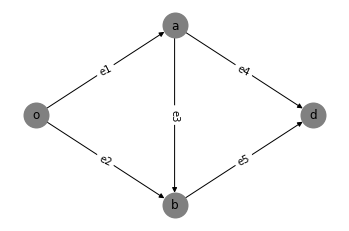

In [9]:
G = nx.DiGraph()
G.add_edges_from([('o','a'),('o','b'),('a','b'),('a','d'),('b','d')])

G['o']['a']['capacity'] = 3
G['o']['b']['capacity'] = 2
G['a']['b']['capacity'] = 2
G['a']['d']['capacity'] = 3
G['b']['d']['capacity'] = 2

pos = {'o': (40, 20), 'a': (60, 35), 'b': (60, 5), 'd': (80, 20)}

labels = ['e1','e2','e3','e4','e5']

zip_operator = zip(G.edges(), labels)
labels = dict(zip_operator)

nx.draw_networkx_edge_labels(G,pos,edge_labels = labels)

nx.draw(G, pos, with_labels = True, node_color='grey', node_size=600,linewidths=1.5)
#plt.savefig("ex1_graph.eps", format='eps')

In [10]:
nx.algorithms.flow.maximum_flow(G,'o','d')

(5, {'o': {'a': 3, 'b': 2}, 'a': {'b': 0, 'd': 3}, 'b': {'d': 2}, 'd': {}})

In [11]:
nx.algorithms.flow.minimum_cut(G,'o','d')

(5, ({'a', 'b', 'o'}, {'d'}))

# B

In [12]:
G_auxB=copy.copy(G)
mfcp1=max_flow_capacities_placement(G_auxB, 1)

There are 4 possible combinations of added capacities with max flow 5
Combinations of added capacities on edges in the form [e1,e2,e3,e4,e5]:
[0, 0, 0, 0, 1]
[0, 0, 0, 1, 0]
[1, 0, 0, 0, 0]
[0, 1, 0, 0, 0]


# C

In [13]:
G_auxC=copy.copy(G)
mfcp2=max_flow_capacities_placement(G_auxC, 2)

There are 3 possible combinations of added capacities with max flow 6
Combinations of added capacities on edges in the form [e1,e2,e3,e4,e5]:
[1, 0, 0, 0, 1]
[1, 0, 0, 1, 0]
[0, 1, 0, 0, 1]


# D

In [14]:
G_auxD=copy.copy(G)
mfcp4=max_flow_capacities_placement(G_auxD, 4)

There are 6 possible combinations of added capacities with max flow 7
Combinations of added capacities on edges in the form [e1,e2,e3,e4,e5]:
[2, 0, 0, 0, 2]
[2, 0, 0, 1, 1]
[1, 1, 0, 0, 2]
[2, 0, 0, 2, 0]
[0, 2, 0, 0, 2]
[1, 1, 0, 1, 1]


## D.b

In [15]:
G_auxD=copy.copy(G)
max_flowD, capacities_combD=max_flow_capacities_placement(G_auxD, 4)
max_sum_comb=[]
max_sum=-np.inf
#iterate on combinations of capacity placements that give a maximum flow
for combination in capacities_combD:
    #generate new graph with added capacity 
    G_auxD1=copy.deepcopy(G)
    for edge in combination:
        G_auxD1[edge[0]][edge[1]]["capacity"]+=1
    #compute sum of cut capacities
    cuts=cuts_compute(G_auxD1)
    c=sum_cut_capacities(cuts, G_auxD1)
    if c==max_sum:
        max_sum_comb.append(combination)
    if c>max_sum:
        max_sum=c
        max_sum_comb=[]
        max_sum_comb.append(combination)
print("The maximum sum of cut capacities is",max_sum,"and comes from combinations:\n",max_sum_comb)

There are 6 possible combinations of added capacities with max flow 7
Combinations of added capacities on edges in the form [e1,e2,e3,e4,e5]:
[2, 0, 0, 0, 2]
[2, 0, 0, 1, 1]
[1, 1, 0, 0, 2]
[2, 0, 0, 2, 0]
[0, 2, 0, 0, 2]
[1, 1, 0, 1, 1]
The maximum sum of cut capacities is 30 and comes from combinations:
 [[('b', 'd'), ('b', 'd'), ('o', 'a'), ('o', 'a')], [('a', 'd'), ('b', 'd'), ('o', 'a'), ('o', 'a')], [('b', 'd'), ('b', 'd'), ('o', 'a'), ('o', 'b')], [('a', 'd'), ('a', 'd'), ('o', 'a'), ('o', 'a')], [('b', 'd'), ('b', 'd'), ('o', 'b'), ('o', 'b')], [('a', 'd'), ('b', 'd'), ('o', 'a'), ('o', 'b')]]


In [16]:
print("There are",len(max_sum_comb),"combinations with maximum sum of cut capacities, \nthus they are all the ones computed in point D")

There are 6 combinations with maximum sum of cut capacities, 
thus they are all the ones computed in point D
